In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import pims

from sklearn import mixture
from sklearn.decomposition import PCA
import time
import sys
import scipy.ndimage
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
#%matplotlib notebook
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)
import warnings
warnings.filterwarnings(action='once')

In [2]:
seg_len = 15

In [3]:
def classify1(features, MX=5):
    newdata = features
    n_components = np.arange(1, MX + 1)
    BIC = np.zeros(n_components.shape)
    lowest_bic = np.infty
    best_gmm = None

    for i, n in enumerate(n_components):        
        gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=0)
        gmm.fit(newdata)
        BIC[i] = gmm.bic(newdata)
        print(BIC[i])
        if BIC[i] < lowest_bic:
            lowest_bic = BIC[i]
            best_gmm = gmm

    best_gmm = GaussianMixture(n_components=best_gmm.n_components, covariance_type='full', random_state=0)
    best_gmm.fit(features)

    print(best_gmm.n_components)
    plt.figure()
    plt.plot(BIC)
    plt.show()
    return best_gmm

def plot_array(arr):
    ny, nx = arr.shape
    xv, yv = np.meshgrid(np.linspace(0, nx, nx), np.linspace(0, ny, ny))
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(xv,yv,arr)
    plt.show()

In [4]:
df = pd.read_csv("data.csv")
df.drop(df.columns[0], inplace=True, axis=1)
scaler = MinMaxScaler()
df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df.columns[2:])
display(df2.describe())
display(df2.head(5))

,x,y,w,h,Rf,mx,my
count,20779.000000,20779.000000,20779.000000,20779.000000,20779.000000,20779.000000,20779.000000
mean,0.489957,0.366771,0.169057,0.351827,0.555880,0.437085,0.514161
std,0.248588,0.250720,0.157797,0.276430,0.222951,0.067668,0.086303
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.352798,0.153646,0.039062,0.116279,0.418972,0.412081,0.483856
50%,0.485401,0.289062,0.125000,0.286822,0.593653,0.436066,0.507277
75%,0.641119,0.541667,0.265625,0.550388,0.725584,0.464998,0.541193
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,x,y,w,h,Rf,mx,my
0,0.501217,0.276042,0.453125,0.790698,0.045686,0.553293,0.394010
1,0.334550,0.122396,0.039062,0.162791,0.049755,0.434981,0.499164
2,0.237226,0.510417,0.335938,0.852713,0.032895,0.402517,0.695412
3,0.339416,0.419271,0.085938,0.038760,0.054317,0.435015,0.499294
4,0.506083,0.276042,0.437500,0.790698,0.086292,0.527376,0.408760


-136915.870024
-189995.2972
-210104.231779
-223070.203208
-237453.746554
5


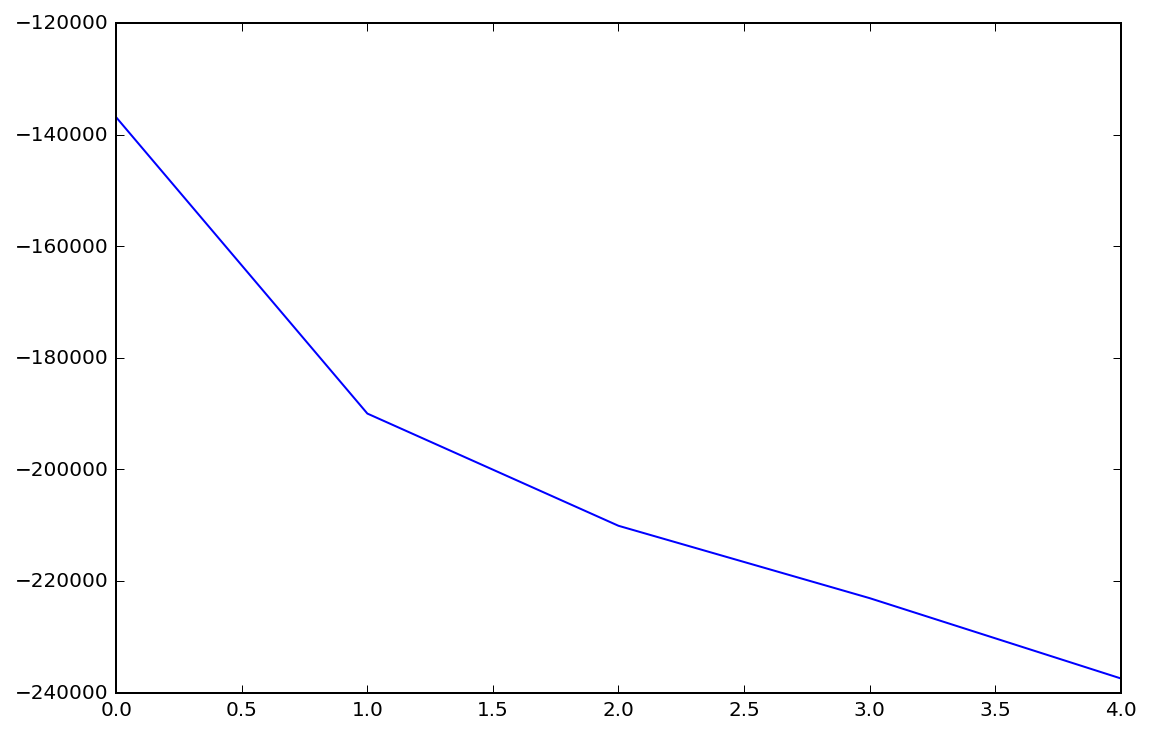

In [5]:
bgmm = classify1(df2)

In [6]:
df3 = pd.DataFrame(bgmm.predict_proba(df2))
df3["time"] = df["time"]
df3["frame"] = df["frame"]
df3 = df3.groupby(['time', 'frame']).agg('max')
df3.reset_index(inplace=True)

display(df3.head(10))

PN = []

last_t = df3.iloc[0]["time"]

pn = []

for i in range(len(df3)):
    r = df3.iloc[i]
    pn.append(r.drop(["time", "frame"]).ravel())
    if r.time - last_t > seg_len:
        last_t = r.time
        PN.append(pn)
        pn = []

print("N =",len(PN))
for i in range(len(PN)):
    print("N[",i,"]=",len(PN[i]))

,time,frame,0,1,2,3,4
0,10.60,265,1.000000,9.884251e-01,0.001327,0.000223,4.687864e-09
1,10.76,269,0.999990,9.910966e-01,0.004184,0.012550,6.892007e-06
2,10.92,273,0.999987,9.919232e-01,0.037920,0.019840,4.540458e-05
3,11.08,277,0.999992,9.952543e-01,0.066371,0.031780,2.815724e-04
4,11.24,281,0.665941,2.136620e-87,0.332577,0.001482,4.294974e-53
5,11.40,285,1.000000,4.527789e-09,0.641375,0.000501,6.680720e-19
6,11.56,289,1.000000,3.173822e-09,0.823410,0.215484,3.745100e-04
7,11.72,293,0.197193,9.948138e-01,0.000014,0.802782,8.965797e-05
8,11.88,297,0.094562,9.936245e-01,0.000064,0.905325,1.393325e-03
9,12.04,301,0.030514,9.870566e-01,0.000169,0.969312,8.882131e-03


N = 56
N[ 0 ]= 91
N[ 1 ]= 94
N[ 2 ]= 94
N[ 3 ]= 94
N[ 4 ]= 94
N[ 5 ]= 94
N[ 6 ]= 94
N[ 7 ]= 94
N[ 8 ]= 92
N[ 9 ]= 94
N[ 10 ]= 94
N[ 11 ]= 94
N[ 12 ]= 94
N[ 13 ]= 94
N[ 14 ]= 94
N[ 15 ]= 94
N[ 16 ]= 94
N[ 17 ]= 94
N[ 18 ]= 94
N[ 19 ]= 94
N[ 20 ]= 94
N[ 21 ]= 94
N[ 22 ]= 94
N[ 23 ]= 94
N[ 24 ]= 94
N[ 25 ]= 94
N[ 26 ]= 94
N[ 27 ]= 94
N[ 28 ]= 94
N[ 29 ]= 94
N[ 30 ]= 94
N[ 31 ]= 94
N[ 32 ]= 94
N[ 33 ]= 94
N[ 34 ]= 94
N[ 35 ]= 94
N[ 36 ]= 94
N[ 37 ]= 94
N[ 38 ]= 94
N[ 39 ]= 94
N[ 40 ]= 94
N[ 41 ]= 94
N[ 42 ]= 94
N[ 43 ]= 94
N[ 44 ]= 94
N[ 45 ]= 94
N[ 46 ]= 92
N[ 47 ]= 94
N[ 48 ]= 90
N[ 49 ]= 94
N[ 50 ]= 94
N[ 51 ]= 94
N[ 52 ]= 94
N[ 53 ]= 94
N[ 54 ]= 92
N[ 55 ]= 94


In [7]:
from hmmlearn import hmm

def my_hmm_score(h, samples):
    s = h.score(samples)
    return 0 if s > 0 else s

hmms1 = []

N = len(PN)

for i in range(N):
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag", random_state=41)
    hmm1.fit(PN[i])    
    hmms1.append(hmm1)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn/base.py:462: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice
/usr/local/lib/python3.5/dist-packages/hmmlearn/utils.py:46: DeprecationWarning: `logsumexp` is deprecated!
Importing

In [8]:
Sij = np.zeros((N,N), np.float64)

for i in range(N):
    for j in range(N):
        s1 = my_hmm_score(hmms1[i], PN[j]) * (1.0 / len(PN[j]))
        s2 = my_hmm_score(hmms1[j], PN[i]) * (1.0 / len(PN[i]))
        Sij[i, j] = 0.5 * (s1 + s2)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn/base.py:462: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


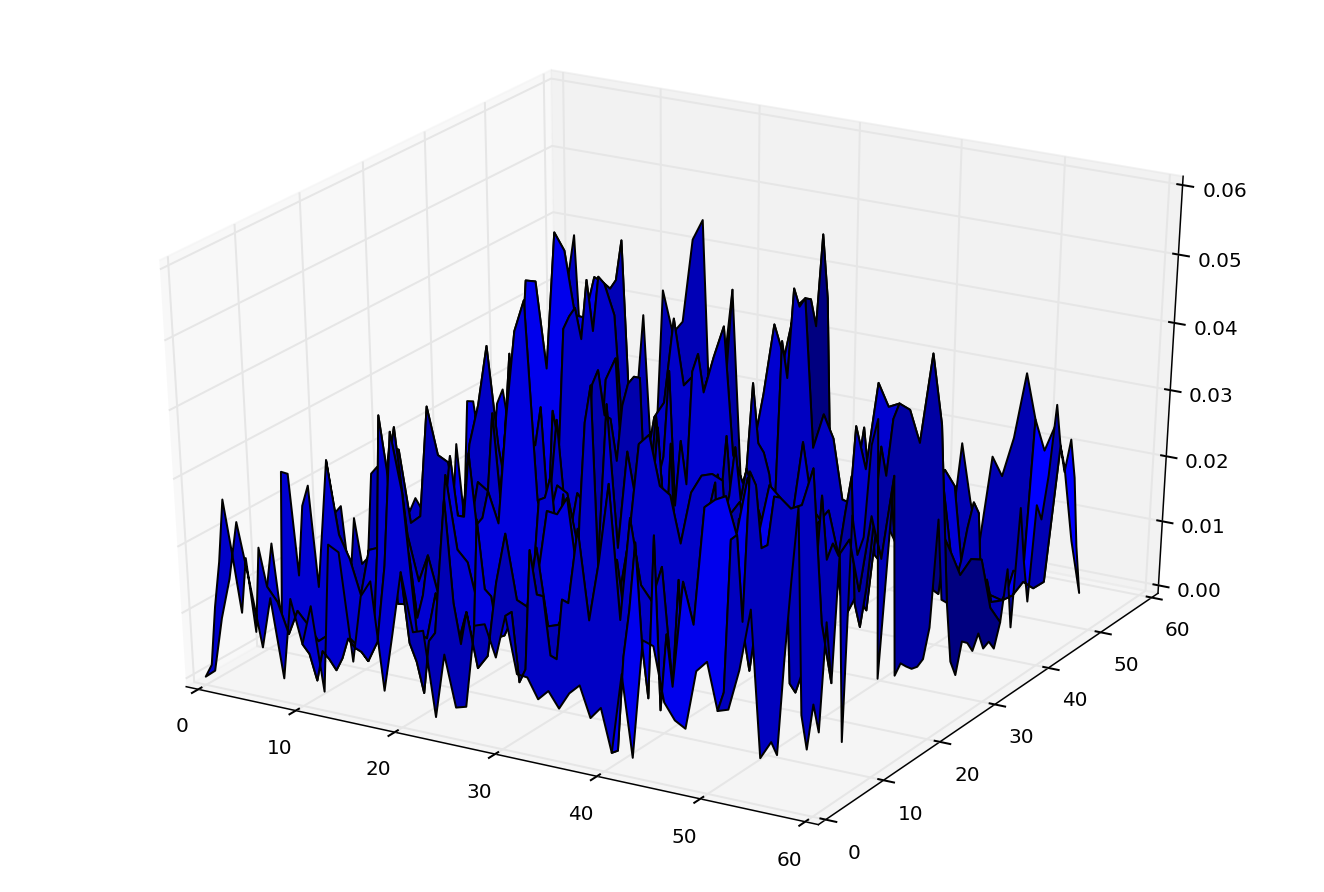

In [9]:
from scipy.linalg import fractional_matrix_power

Lij = np.zeros((N,N), np.float64)

for i in range(N):
    s1 = 0
    for j in range(N):
        s1 += Sij[i, j]
    Lij[i, i] = s1
Lij2 = fractional_matrix_power(Lij, -0.5)
Snorm = np.dot(np.dot(Lij2, Sij), Lij2).astype('float64')
plot_array(Snorm)

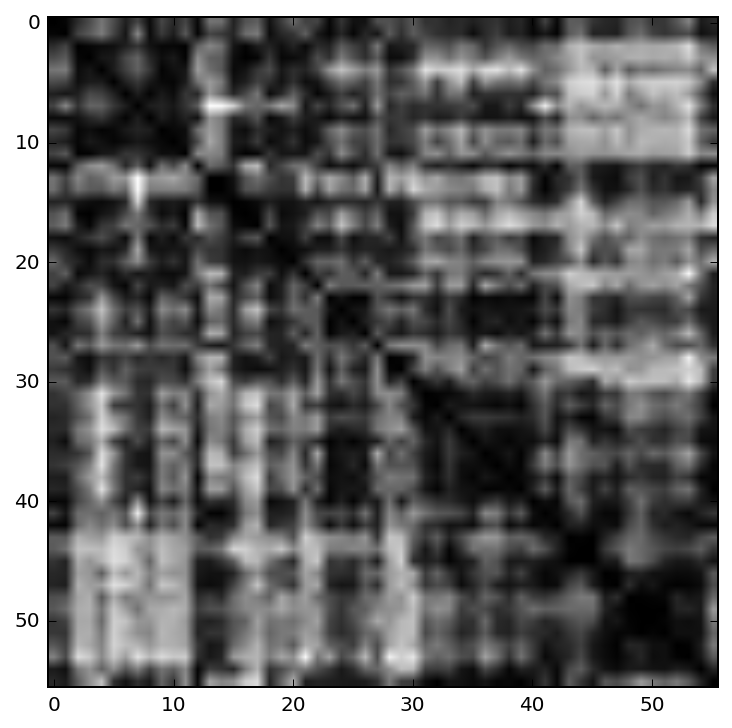

In [10]:
plt.figure()
plt.imshow(Snorm, cmap='gray')
plt.show()

array([[  9.37655625e-02,   1.33284627e-01,   1.60205293e-01,
          1.49119609e-01,   1.40956036e-01,   1.60489182e-01,
          9.84232501e-02,   1.80159714e-01,   1.04118227e-01,
          1.26934798e-01,   1.36101295e-01],
       [  5.18971154e-03,  -1.28381717e-01,  -1.16444432e-01,
         -2.06293212e-01,  -1.95380659e-01,   1.01037238e-01,
         -9.28216926e-02,  -1.94946228e-01,  -7.33525215e-02,
         -9.34533164e-02,  -1.85010466e-01],
       [  8.13612370e-02,   1.06533231e-01,   2.17977361e-01,
         -4.00103371e-02,  -5.17249220e-02,  -2.84006119e-01,
         -1.17248991e-01,  -1.91262693e-01,  -4.62806091e-04,
         -1.76034724e-01,   9.29865347e-02],
       [  7.94564884e-02,   2.06648476e-01,  -2.38119311e-01,
          3.71069586e-02,  -1.15566372e-01,   3.32544367e-02,
          1.49308362e-01,  -1.91917410e-01,   2.40147186e-01,
          1.14450011e-02,  -6.95776324e-02],
       [  8.73026608e-03,   8.15768671e-02,   1.74400610e-01,
          2.32

-434.573112199
-237.958411713
-570.970458414
-597.694218203
-478.827959427
-559.424459997
-548.633736301
-54.3629015921
115.151862522
449.458654383
700.740039217
4


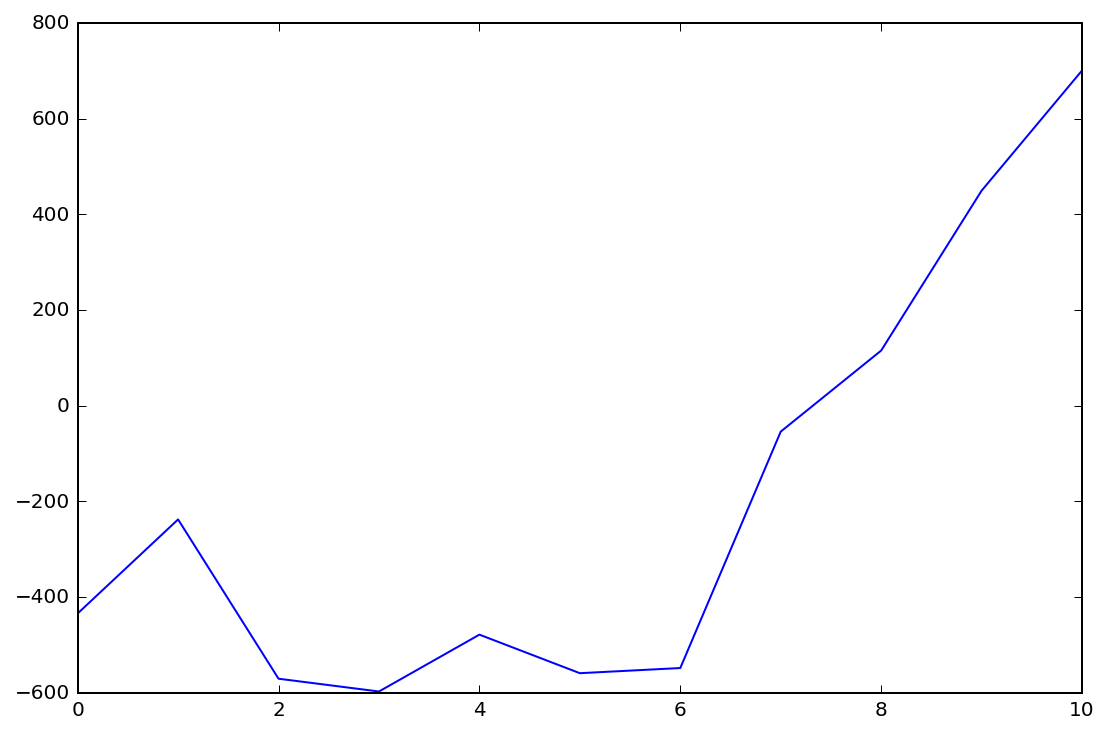

In [11]:
Km = int(N / 5)
Snorm_vals, Snorm_vecs = np.linalg.eig(Snorm)
indices = np.argsort(Snorm_vals)[::-1][:Km]
top_vecs = Snorm_vecs[indices].T
display(top_vecs)
eig_gmm = classify1(top_vecs, Km)
finalK = eig_gmm.n_components

In [12]:
final_hmms = []
final_nk = []
top_classes = eig_gmm.predict(top_vecs)
for i in range(finalK):    
    tmp1 = []
    num = 0
    tmp1_ls = []
    for j in range(N):
        if top_classes[j] == i:
            tmp1 += PN[j]
            tmp1_ls.append(len(PN[j]))
            num += 1
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag", random_state=46)
    hmm1.fit(tmp1, tmp1_ls)
    final_hmms.append(hmm1)
    final_nk.append(num)    

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn/base.py:462: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice
/usr/local/lib/python3.5/dist-packages/hmmlearn/utils.py:46: DeprecationWarning: `logsumexp` is deprecated!
Importing

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn/base.py:462: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice


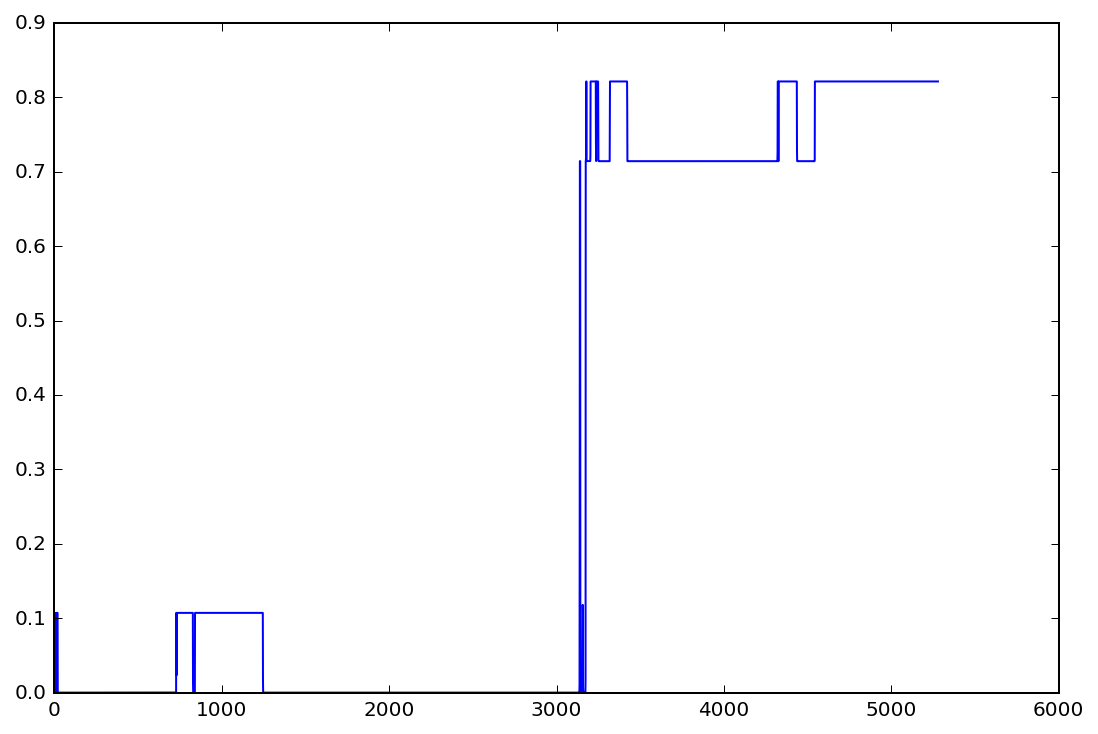

In [71]:
def calc_final_prob(samples):
    res = 0
    for i in range(finalK):                                
        res += np.exp(my_hmm_score(final_hmms[i], samples)) * (float(final_nk[i]) / float(N))        
    return res

TestPN = df3.drop(["time", "frame"], axis=1)
test_arr = []
scrs = []
scrs_prob = []
j = 1
for i in range(len(TestPN)):
    r = TestPN.iloc[i].ravel()
    test_arr.append(r)
    prb = calc_final_prob(test_arr)    
    prb2 = np.log(prb)
    if prb2 == -np.inf:
        prb2 = -1000;    
    scrs.append(prb2 / j)
    scrs_prob.append(prb)
    j += 1
    if j >= 200000:
        j -= 1
        del test_arr[0]
        
plt.figure()
plt.plot(scrs_prob)
plt.show()

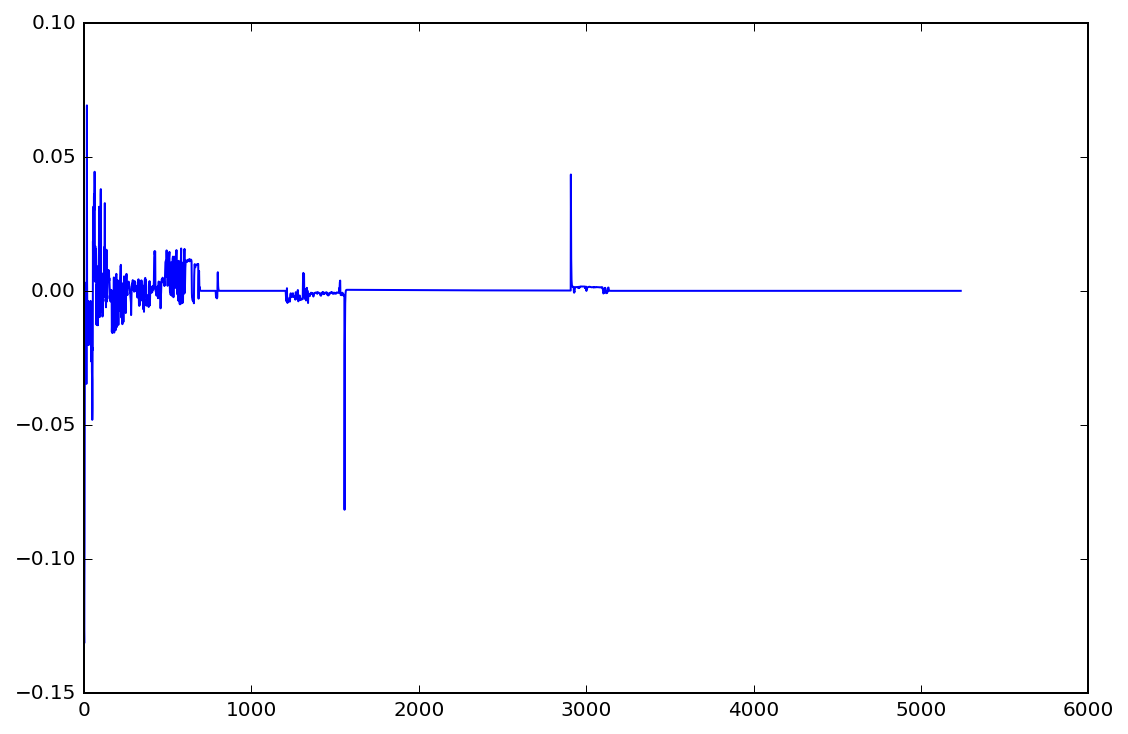

In [78]:
import traceback

Qt = 0
alpha = 0.5

first_frm = 40
first_frm_num = 0

qts = {}
qts_lst = []
for i in range(len(scrs)):
    if i == 0:
        Qt = scrs[0]
    else:
        Qt = (1 - alpha) * Qt + alpha * (scrs[i] - scrs[i - 1])        
    qts[df3.iloc[i]["frame"]] = Qt
    qts_lst.append(Qt)
    if i == first_frm:
        first_frm_num = df3.iloc[i]["frame"]
            
plt.figure()
plt.plot(qts_lst[first_frm:])
plt.show()

cap = cv2.VideoCapture('z3.avi')
ok, frame = cap.read()
aspect = float(frame.shape[1]) / frame.shape[0]
cap.release()
cap = cv2.VideoCapture('z3.avi')

try:
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        frame = cv2.resize(frame, (int(240 * aspect), 240), interpolation = cv2.INTER_AREA)    
        fnum = cap.get(cv2.CAP_PROP_POS_FRAMES)    
        delay = 1
        if (fnum >= first_frm_num) and (fnum in qts):
            if qts[fnum] < -0.015:
                cv2.rectangle(frame, (0,0), (frame.shape[1], frame.shape[0]), (0,0,255), 10)
                delay = 0
        cv2.imshow('frame', frame)
        k = cv2.waitKey(delay) & 0xff
        if k == 32:
            k = cv2.waitKey() & 0xff
        if k == 27:
            break
except Exception as e:    
    traceback.print_exc()

cap.release()
cv2.destroyAllWindows()